In [40]:
import pandas as pd
import numpy as np 
from numpy import mean
from numpy import std
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier 
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 

In [41]:
train=pd.read_csv('train_jobathon.csv')

In [61]:
train['Is_Lead'].value_counts()### the target data is  imbalanced , more number of zeroes and less number of 1's 

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [629]:
train.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [103]:
train.isna().sum()## checking for the number of null values.

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [631]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [42]:
categorical=train.select_dtypes(include=[np.object])
categorical ### taking the categorical type data separately 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,NNVBBKZB,Female,RG268,Other,X3,No,No
1,IDD62UNG,Female,RG277,Salaried,X1,No,No
2,HD3DSEMC,Female,RG268,Self_Employed,X3,No,Yes
3,BF3NC7KV,Male,RG270,Salaried,X1,No,No
4,TEASRWXV,Female,RG282,Salaried,X1,No,No
...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,RG284,Self_Employed,X3,NaN,No
245721,HFNB7JY8,Male,RG268,Salaried,X1,No,Yes
245722,GEHAUCWT,Female,RG281,Salaried,X1,No,No
245723,GE7V8SAH,Female,RG273,Salaried,X1,No,No


In [61]:
number=train.select_dtypes(include=[np.number])### taking the numerical type data separately 
number.drop('Is_Lead',axis=1,inplace=True)

In [44]:
number

,Age,Vintage,Avg_Account_Balance
0,73,43,1045696
1,30,32,581988
2,56,26,1484315
3,34,19,470454
4,30,33,886787
...,...,...,...
245720,51,109,1925586
245721,27,15,862952
245722,26,13,670659
245723,28,31,407504


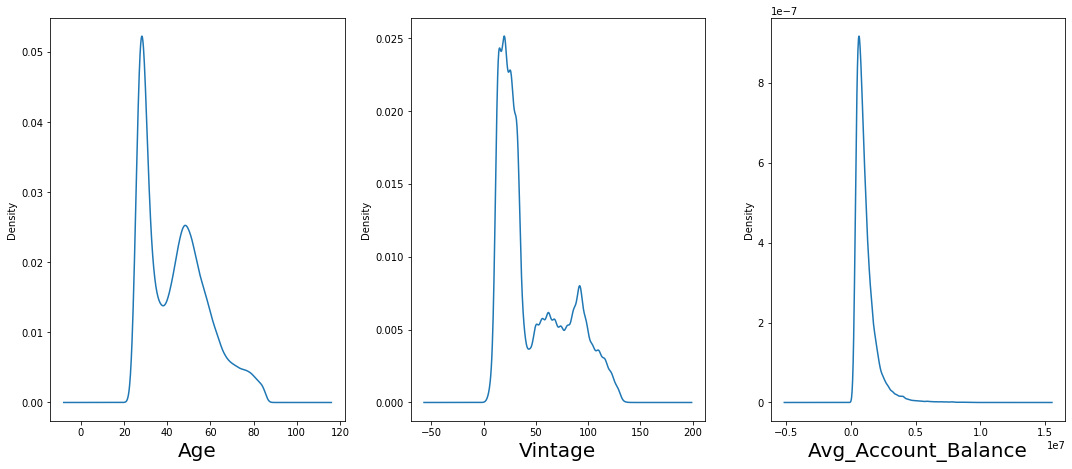

In [46]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in number:
    if plotnumber<=16:
        ax = plt.subplot(4,4,plotnumber)
        number[column].plot(kind='kde')
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.tight_layout()### checking the dstribution of the numerical data sets 

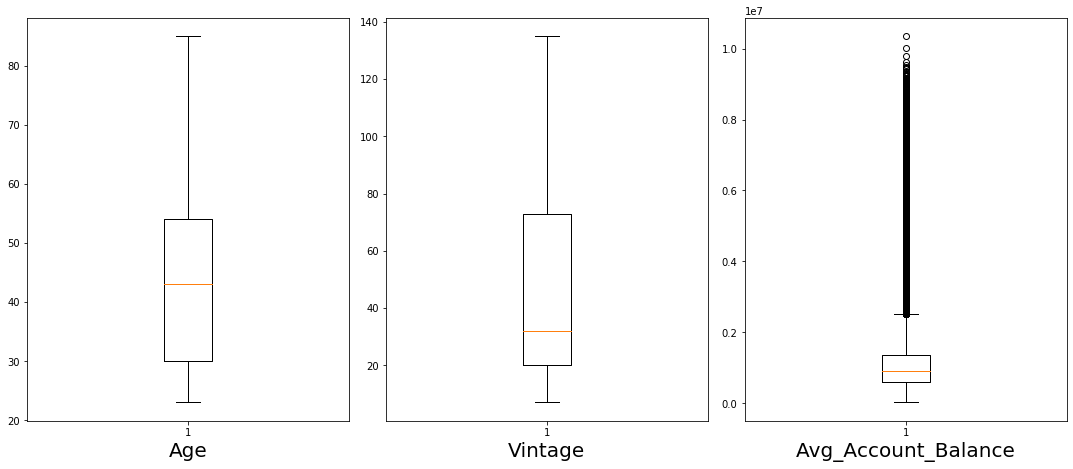

In [47]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in number:
    if plotnumber<=16:
        ax = plt.subplot(4,4,plotnumber)
        plt.boxplot(number[column])
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.tight_layout() ### ouliers are present but are important part of data as the roc score decreses on removing them.

In [570]:
number.columns

Index(['Age', 'Vintage', 'Avg_Account_Balance'], dtype='object')

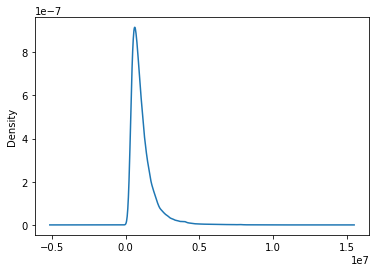

In [689]:
number['Avg_Account_Balance'].plot(kind='kde')

In [59]:
categorical.drop("ID",axis=1,inplace=True)### dropping the ID column in categorical data frame as it is not necessary 

C:\Users\Madarchod\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
Y=train['Is_Lead'] ## taking target variable for usage in Y 
Y.shape

(245725,)

In [62]:
categorical

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,0,18,1,2,0,0
1,0,27,2,0,0,0
2,0,18,3,2,0,1
3,1,20,2,0,0,0
4,0,32,2,0,0,0
...,...,...,...,...,...,...
245720,1,34,3,2,2,0
245721,1,18,2,0,0,1
245722,0,31,2,0,0,0
245723,0,23,2,0,0,0


In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in categorical:
    categorical[column]= le.fit_transform(categorical[column])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [58]:
categorical

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,179194,0,18,1,2,0,0
1,131013,0,27,2,0,0,0
2,121520,0,18,3,2,0,1
3,57273,1,20,2,0,0,0
4,209602,0,32,2,0,0,0
...,...,...,...,...,...,...,...
245720,60529,1,34,3,2,2,0
245721,122463,1,18,2,0,0,1
245722,111270,0,31,2,0,0,0
245723,111156,0,23,2,0,0,0


In [49]:
number

,Age,Vintage,Avg_Account_Balance
0,73,43,1045696
1,30,32,581988
2,56,26,1484315
3,34,19,470454
4,30,33,886787
...,...,...,...
245720,51,109,1925586
245721,27,15,862952
245722,26,13,670659
245723,28,31,407504


In [65]:
X=pd.concat([categorical,number], axis=1)
X.columns

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Age', 'Vintage', 'Avg_Account_Balance'],
      dtype='object')

In [66]:
X

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active,Age,Vintage,Avg_Account_Balance
0,0,18,1,2,0,0,73,43,1045696
1,0,27,2,0,0,0,30,32,581988
2,0,18,3,2,0,1,56,26,1484315
3,1,20,2,0,0,0,34,19,470454
4,0,32,2,0,0,0,30,33,886787
...,...,...,...,...,...,...,...,...,...
245720,1,34,3,2,2,0,51,109,1925586
245721,1,18,2,0,0,1,27,15,862952
245722,0,31,2,0,0,0,26,13,670659
245723,0,23,2,0,0,0,28,31,407504


In [67]:
X.columns

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Age', 'Vintage', 'Avg_Account_Balance'],
      dtype='object')

In [68]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state=4444, stratify=Y) ## splitting the data into train and test dataset using the stratify to overcome class imbalancement .

In [87]:
model = XGBClassifier(class_weight='balanced')
model3= LGBMClassifier()

In [92]:
kfold = KFold(n_splits=10) ## applying k fold 
results = cross_val_score(model3, x_train,y_train, cv=kfold)

In [699]:
results 

array([0.85957678, 0.86125882, 0.85718937, 0.85587932, 0.86103424,
       0.86542949, 0.86141408, 0.86201096, 0.86081719, 0.85766998])

In [98]:
model.fit(x_train,y_train)## training the XGBModel

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [97]:
model3.fit(x_train,y_train) ## training LGBm over train dataset 

LGBMClassifier()

In [99]:
pred_train_xgb=model.predict_proba(x_test)[:,1] ##predicting target on x_test using XGBClassifier 

In [100]:
pred_train_lgb=model3.predict_proba(x_test)[:,1]##predicting target on x_test using LGBMClassifier

In [101]:
roc_auc_score(y_test,pred_train_lgb) ## checking  ROC score for LGBM

0.8738766844101997

In [102]:
roc_auc_score(y_test,pred_train_xgb) ## checking  ROC score for XGboost 

0.8725545791426486

In [ ]:
### as the score for LGBM is high we will use LGBmClassifer 

In [77]:
##performing the operations on test data
test=pd.read_csv('test_hackathon.csv')

In [104]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [105]:
categorical_test=test.select_dtypes(include=[np.object])###grouping categorical features
categorical_test.drop('ID',axis=1,inplace=True)### dropping the non required ID column

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
C:\Users\Madarchod\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [106]:
categorical_test.isna().sum()

Gender                0
Region_Code           0
Occupation            0
Channel_Code          0
Credit_Product    12522
Is_Active             0
dtype: int64

In [113]:
number_test=test.select_dtypes(include=[np.number])### grouping the numerical columns 
number_test

,Age,Vintage,Avg_Account_Balance
0,29,25,742366
1,43,49,925537
2,31,14,215949
3,29,33,868070
4,29,19,657087
...,...,...,...
105307,52,86,4242558
105308,55,86,1159153
105309,35,15,1703727
105310,53,93,737178


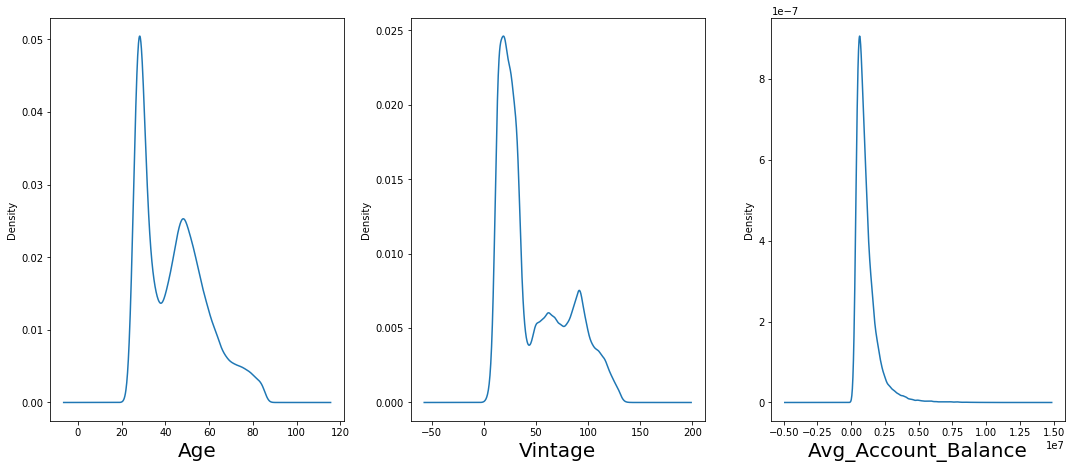

In [108]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in number:
    if plotnumber<=16:
        ax = plt.subplot(4,4,plotnumber)
        number_test[column].plot(kind='kde')
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.tight_layout()

In [112]:
categorical_test

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,1,4,1,0,1,0
1,1,18,1,1,2,0
2,1,20,2,0,0,0
3,1,22,1,0,0,0
4,0,20,1,0,0,0
...,...,...,...,...,...,...
105307,1,18,2,1,1,1
105308,1,27,1,1,1,0
105309,1,4,2,3,0,0
105310,1,4,1,2,0,1


In [110]:
from sklearn.preprocessing import LabelEncoder ### using the labelencoder for encoding the categorical variables 
le = LabelEncoder()
for column in categorical_test:
    categorical_test[column]= le.fit_transform(categorical_test[column])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [111]:
categorical_test

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,1,4,1,0,1,0
1,1,18,1,1,2,0
2,1,20,2,0,0,0
3,1,22,1,0,0,0
4,0,20,1,0,0,0
...,...,...,...,...,...,...
105307,1,18,2,1,1,1
105308,1,27,1,1,1,0
105309,1,4,2,3,0,0
105310,1,4,1,2,0,1


In [114]:
number_test

,Age,Vintage,Avg_Account_Balance
0,29,25,742366
1,43,49,925537
2,31,14,215949
3,29,33,868070
4,29,19,657087
...,...,...,...
105307,52,86,4242558
105308,55,86,1159153
105309,35,15,1703727
105310,53,93,737178


In [115]:
test_final=pd.concat([categorical_test,number_test], axis=1)## final dataframe for the test

In [663]:
X.columns

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Gender_Occupation', 'Age', 'Vintage',
       'Avg_Account_Balance'],
      dtype='object')

In [664]:
test_final.columns

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Gender_Occupation', 'Age', 'Vintage',
       'Avg_Account_Balance'],
      dtype='object')

In [116]:
sample_submission2=pd.DataFrame(test['ID']) ## creating the data frame

In [117]:
pred_test_lgb = model3.predict_proba(test_final)[:,1]
sample_submission2['Is_Lead'] = pred_test_lgb
sample_submission2.set_index('ID').to_csv('pred_test_lgb_final_label_encode.csv')